# Example of component

In [1]:
import os
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import jax.numpy as jnp
import multihist as mh

import appletree as apt
from appletree.utils import get_file_path

Using Normal as an approximation of Binomial
Using aptext package from https://github.com/XENONnT/applefiles


In [2]:
# constrain the GPU memory usage

apt.set_gpu_memory_usage(0.2)

## Define component

### ComponentSim

In [3]:
# The components is associated with bins, so first we load bins
data = pd.read_csv(get_file_path('data_Rn220.csv'))
bins_cs1, bins_cs2 = apt.utils.get_equiprob_bins_2d(
    data[['cs1', 'cs2']].to_numpy(),
    [15, 15],
    order=[0, 1],
    x_clip=[0, 100],
    y_clip=[1e2, 1e4],
    which_np=jnp
)

In [4]:
# Initialize component
er = apt.ERBand(bins=[bins_cs1, bins_cs2], bins_type='irreg')

In [5]:
# Deduce the workflow(datastructure)
er.deduce(
    data_names=['cs1', 'cs2'], # 'eff'(efficiency) is always simulated
    func_name='simulate'
)
er.rate_name = 'er_rate' # also we have to specify a normalization factor of the component

# Compile ER script
# This is meta-programing because  appletree can generate codes dynamically
er.compile()

In [6]:
# For reference, this is the compiled code, the function is stored in appletree.share._cached_functions
print(er.code)

from functools import partial
from jax import jit
from appletree.plugins import PositionSpectra
from appletree.plugins import UniformEnergySpectra
from appletree.plugins import RecombFluct
from appletree.plugins import mTI
from appletree.plugins import Quanta
from appletree.plugins import TrueRecombER
from appletree.plugins import IonizationER
from appletree.plugins import DriftLoss
from appletree.plugins import RecombinationER
from appletree.plugins import ElectronDrifted
from appletree.plugins import PositionRecon
from appletree.plugins import S2Correction
from appletree.plugins import S2PE
from appletree.plugins import S2
from appletree.plugins import S1Correction
from appletree.plugins import PhotonDetection
from appletree.plugins import S1PE
from appletree.plugins import S1
from appletree.plugins import S2CutAccept
from appletree.plugins import S1CutAccept
from appletree.plugins import S1ReconEff
from appletree.plugins import S2Threshold
from appletree.plugins import Eff
from appl

### ComponentFixed

In [7]:
# Initialize component, not based on simulation, but the input template
ac = apt.AC(bins=[bins_cs1, bins_cs2], bins_type='irreg', file_name='AC_Rn220.pkl')
ac.rate_name = 'ac_rate'

# Do not forget to deduce
ac.deduce()

# Of course these initialization process looks messy, but we will do the initialization automatically in context

## Load parameters

In [8]:
# Of course we have to load parameters(and their priors) in simulation

par_manager = apt.Parameter(get_file_path('er.json'))
par_manager.sample_init()
parameters = par_manager.get_all_parameter()

## Simulation

In [9]:
# Really do the simulation

batch_size = int(1e6)
key = apt.randgen.get_key(seed=137)

key, (cs1, cs2, eff) = er.simulate(key, batch_size, parameters)

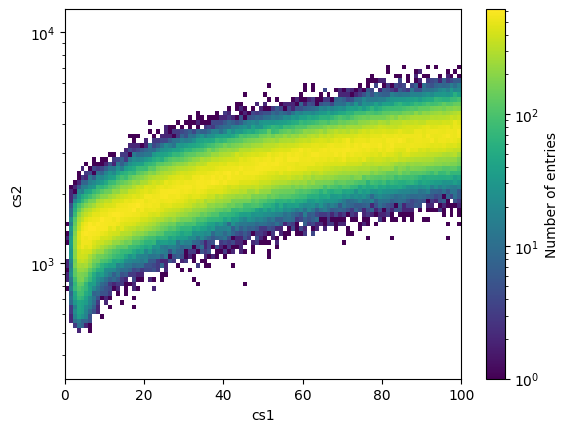

In [10]:
# Just to show the histogram

h, be = jnp.histogramdd(
    jnp.asarray([cs1, cs2]).T,
    bins=(jnp.linspace(0, 100, 101), jnp.logspace(2.5, 4.1, 81)),
    weights=eff
)

h = mh.Histdd.from_histogram(
    np.array(h), 
    be, 
    axis_names=['cs1', 'cs2']
)
h.plot(norm=LogNorm())
plt.yscale('log')
plt.show()

## Simulation and make equiprob hist

In [11]:
# Actually `simulate_hist` is just a wrapper of `simulate`

batch_size = int(1e6)
key = apt.randgen.get_key(seed=137)
key, h = er.simulate_hist(key, batch_size, parameters)

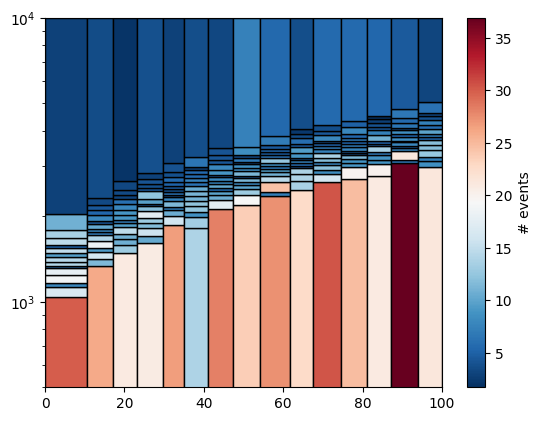

In [12]:
apt.utils.plot_irreg_histogram_2d(bins_cs1, bins_cs2, h, density=False)
plt.yscale('log')
plt.ylim(5e2, 1e4)
plt.show()

In [13]:
h = ac.simulate_hist(parameters)

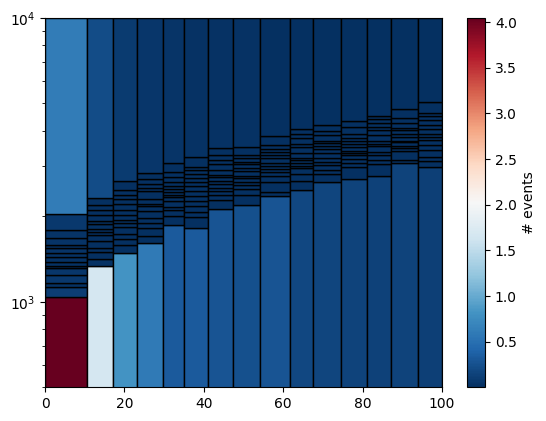

In [14]:
apt.utils.plot_irreg_histogram_2d(bins_cs1, bins_cs2, h, density=False)
plt.yscale('log')
plt.ylim(5e2, 1e4)
plt.show()

## Speed test

In [15]:
@apt.utils.timeit
def test(key, batch_size, parameters):
    return er.simulate_hist(key, batch_size, parameters)

In [16]:
@apt.utils.timeit
def benchmark():
    key = apt.randgen.get_key()
    for _ in range(100):
        key, _ = test(key, int(1e6), parameters)

In [17]:
benchmark()

 Function <benchmark> starts.
 Function <test> starts.
 Function <test> ends! Time cost = 8.48 msec.
 Function <test> starts.
 Function <test> ends! Time cost = 4.53 msec.
 Function <test> starts.
 Function <test> ends! Time cost = 8.02 msec.
 Function <test> starts.
 Function <test> ends! Time cost = 7.70 msec.
 Function <test> starts.
 Function <test> ends! Time cost = 4.23 msec.
 Function <test> starts.
 Function <test> ends! Time cost = 7.32 msec.
 Function <test> starts.
 Function <test> ends! Time cost = 4.84 msec.
 Function <test> starts.
 Function <test> ends! Time cost = 4.98 msec.
 Function <test> starts.
 Function <test> ends! Time cost = 4.15 msec.
 Function <test> starts.
 Function <test> ends! Time cost = 4.27 msec.
 Function <test> starts.
 Function <test> ends! Time cost = 6.68 msec.
 Function <test> starts.
 Function <test> ends! Time cost = 3.86 msec.
 Function <test> starts.
 Function <test> ends! Time cost = 5.78 msec.
 Function <test> starts.
 Function <test> ends!